# Project done by
  1. Tao Qiankuan (U2320044B)
  * contribution: task1, task4
  2. Guan Xiaoxi (U2320285A)
  * contribution: task2, task3, task4

# Project Description
##  Environment:
  As shown below, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. The trained agent makes the decision to push the cart to the left or right based on the cart position, velocity, and the pole angle, angular velocity.

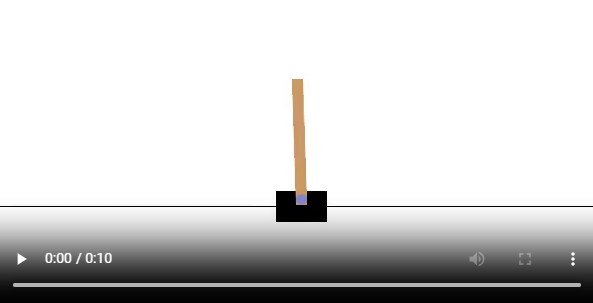

## Solution:
  We trained a Proximal Polixy Optimization (PPO) Agent to the CartPole problem considering following factors:

  1. Sample Efficiency:
    PPO is designed to be sample efficient compared to DQN network. It makes good use of collected data, meaning it can learn effective policies without needing an enormous number of interactions with the environment, while DQN needs experience buffer to break down data corelation and stablize learning
    
  2. Robust Performance:
    The CartPole problem is often used as a benchmark because it requires balancing exploration and exploitation in a straightforward way. PPO's design balances these two aspects effectively, allowing it to converge reliablility to a good policy.

# PPO Process
  1. Define two networks: Policy Network and Value Network
  2. Update PPO policy:
    1. Calculate General Advantage Estimates (GAE) by compute_advantage
    2. Compute policy update by cliping target function

  3. iteratively update within K_epoch
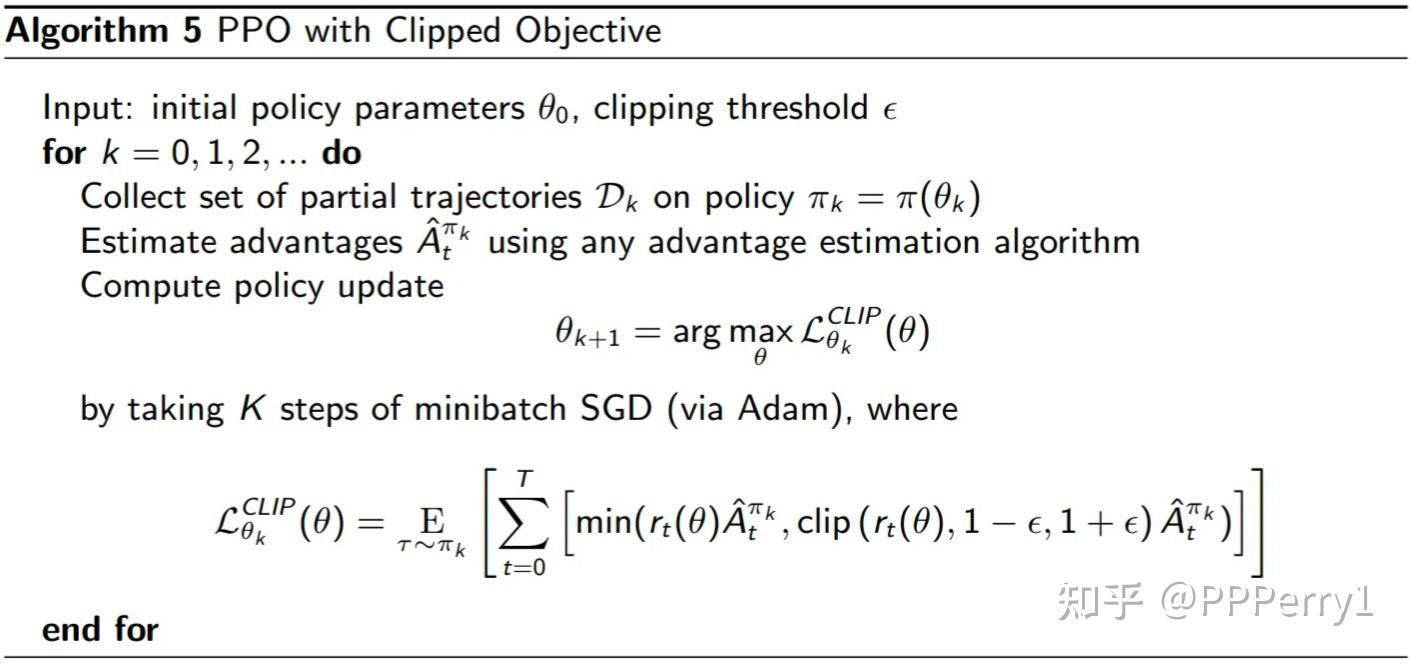

Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2017, July 20). Proximal Policy optimization Algorithms. arXiv.org. https://arxiv.org/abs/1707.06347

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.

## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.02497412  0.02682057 -0.01098384 -0.01729968]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.0244377  -0.16814215 -0.01132983  0.27189758]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

##General Structure of Our PPO Model
####main training loop (for episodes)

- agent.take_action(state) -->**actor chooses the action**

- agent.update(transition_dict)          -->**optimize by experiences**  
    
    - compute TD_target = r_t + γ * V(s{t+1}) --> **estimate the return using reward and next state's value**        

    - compute TD error δ = TD_target - V(s{t}) --> **temporal difference error
(difference between estimated return and current value)**

    - compute Advantage (agent.gae)     -->**use the TD errors (δ) to calculate a smoothed advantage estimate using GAE**

    - repeat for self.epochs times     

         - log_probs = log(π(a|s))   -->**logarithm of current policy**

         - old_log_probs         -->**the old policy**

         - ratio = exp(log - old_log) -->**calculate ratio r = current_policy/old_policy, using logarithm to decrease numerical instability**

         - actor_loss = min(r* A, clipped* A) -->**choose the minimum among r·A and clipped_ratio·A, calculate loss for the policy network**

         - critic_loss = MSE(V(s), target) -->**compute loss for the value network**

         - optimizer.step()        -->**optimize both the actor and the critic**


# Define PolicyNet and ValueNet

In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Define PPO class and a helper function for visualization

In [ ]:
class PPO:
    """PPO with clip"""
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.FloatTensor([state]).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def gae(self, td_delta):
        td_delta = td_delta.detach().numpy()
        advantages_list = []
        advantage = 0.0
        for delta in td_delta[::-1]:
            advantage = self.gamma * self.lmbda * advantage + delta
            advantages_list.append(advantage)
        advantages_list.reverse()
        return torch.FloatTensor(advantages_list)

    def update(self, transition_dist):
        states = torch.FloatTensor(transition_dist['states']).to(self.device)
        actions = torch.tensor(transition_dist['actions']).reshape((-1, 1)).to(self.device)
        rewards = torch.FloatTensor(transition_dist['rewards']).reshape((-1, 1)).to(self.device)
        next_states = torch.FloatTensor(transition_dist['next_states']).to(self.device)
        dones = torch.FloatTensor(transition_dist['dones']).reshape((-1, 1)).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)

        advantage = self.gae(td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ration = torch.exp(log_probs - old_log_probs)
            surr1 = ration * advantage
            surr2 = torch.clamp(ration, 1-self.eps, 1+self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()


def moving_average(a, window_size): #curve smoothing
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))




Iteration 9: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s, episode=500, return=500.000]

Model saved to D:/ppo_checkpoint.pth


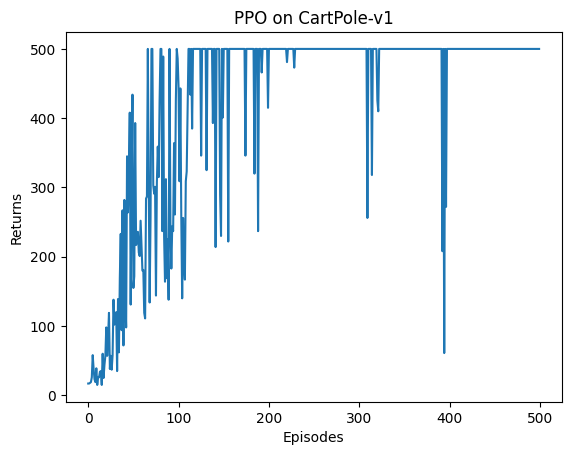

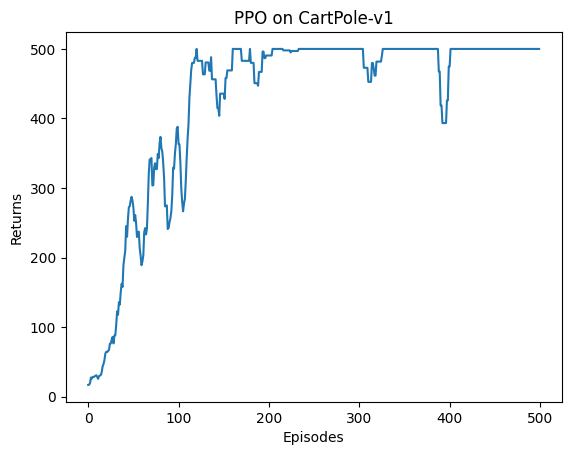

In [ ]:
  # Hyperparameters
  actor_lr = 1e-3   # Policy learning rate
  critic_lr = 1e-2  # Value function learning rate
  num_episodes = 500
  hidden_dim = 128
  gamma = 0.98    # Discount factor
  lmbda = 0.95    # General advantage estimation lmbda
  epochs = 10     # update policy for K epochs
  eps = 0.2       # clip parameter
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Choose to use GPU if it's available

  #Initialize CartPole Environment
  env_name = "CartPole-v1"
  env = gym.make(env_name)
  torch.manual_seed(0)
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n
  agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

  #Start Training
  return_list = []    # record return
  for i in range(10):
      with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:   # Progress Visualization
          for i_episode in range(int(num_episodes / 10)):
              episode_return = 0
              transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
              state = env.reset()
              done = False
              while not done:
                  action = agent.take_action(state)
                  next_state, reward, done, info = env.step(action)
                  done = done
                  transition_dict['states'].append(state)
                  transition_dict['actions'].append(action)
                  transition_dict['next_states'].append(next_state)
                  transition_dict['rewards'].append(reward)
                  transition_dict['dones'].append(done)
                  state = next_state
                  episode_return += reward
              return_list.append(episode_return)
              agent.update(transition_dict)
              if (i_episode + 1) % 10 == 0:
                  pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                    'return': '%.3f' % np.mean(return_list[-10:])})
              pbar.update(1)




  episodes_list = list(range(len(return_list)))
  plt.plot(episodes_list, return_list)
  plt.xlabel('Episodes')
  plt.ylabel('Returns')
  plt.title(f'PPO on {env_name}')
  plt.show()

  mv_return = moving_average(return_list, 9)
  plt.plot(episodes_list, mv_return)
  plt.xlabel('Episodes')
  plt.ylabel('Returns')
  plt.title(f'PPO on {env_name}')
  plt.show()

In [ ]:
import os
torch.save({
    'actor_state_dict': agent.actor.state_dict(),
    'critic_state_dict': agent.critic.state_dict(),
    'actor_optimizer_state_dict': agent.actor_optimizer.state_dict(),
    'critic_optimizer_state_dict': agent.critic_optimizer.state_dict(),
    'return_list': return_list,
    'episode': num_episodes
}, 'ppo_checkpoint.pth')


In [ ]:
from google.colab import files
files.download('ppo_checkpoint.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
checkpoint_path = 'ppo_checkpoint.pth'

checkpoint = torch.load(checkpoint_path, map_location=device)

agent.actor.load_state_dict(checkpoint['actor_state_dict'])
agent.critic.load_state_dict(checkpoint['critic_state_dict'])
agent.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
agent.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])
return_list = checkpoint.get('return_list', [])
start_episode = checkpoint.get('episode', 0)

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. We apply the trained PPO agent here to show the final results.

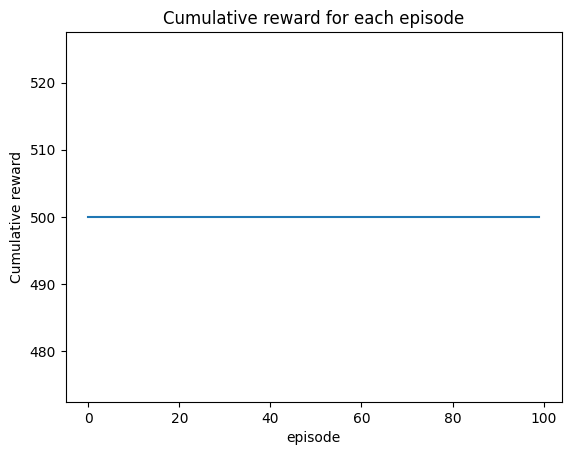

In [ ]:
episodes_result = []
for episode in range(100):
    observation = env.reset()
    cumulative_reward = 0
    done = False
    while not done:
        action = agent.take_action(observation)
        observation, reward, done, info = env.step(action)
        cumulative_reward += reward
    episodes_result.append(cumulative_reward)
plt.plot(episodes_result)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
my_result = np.array(episodes_result)
print("Average cumulative reward:", my_result.mean())
print("Is my agent good enough?", my_result.mean() > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = agent.take_action(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

PPO Agent frame in Task 1 is from PPO algorithm. (n.d.). https://hrl.boyuai.com/chapter/2/ppo%E7%AE%97%E6%B3%95